# <center>자율주행 보조 시스템 만들기</center>



# <참고>
- 
- 

In [2]:
# 주요 라이브러리 버전 확인
import tensorflow as tf
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = '../data/230223/'

print(tf.__version__)

/Users/louan/.pyenv/versions/3.9.13/envs/img/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.11.0


In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-03-02 18:49:19.947226: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-02 18:49:19.947684: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2023-03-02 18:49:20.146783: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


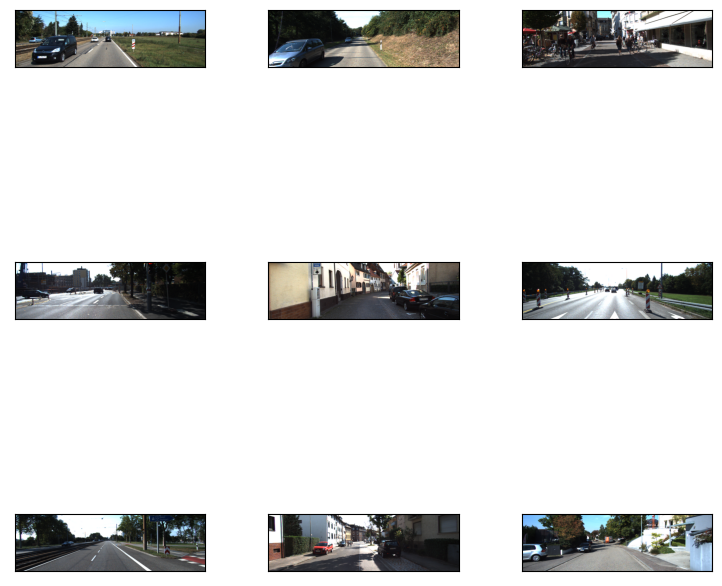

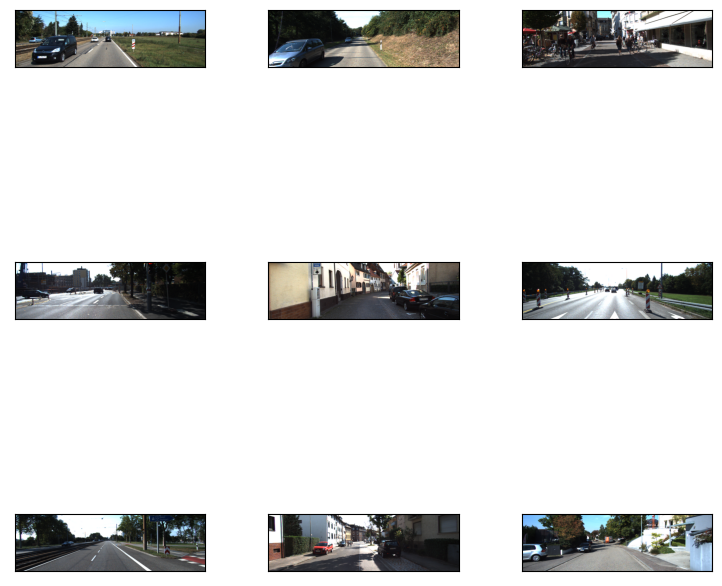

In [4]:
tfds.show_examples(ds_train, ds_info)

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.3.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='../data/230223/kitti/3.3.0',
    file_format=tfrecord,
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/file_name': Text(shape=(), dtype=string),
        'objects': Sequence({
            'alpha': float32,
          

## (2) 데이터 직접 확인하기
이번에는 데이터셋을 직접 확인하는 시간을 갖도록 하겠습니다. ds_train.take(1)을 통해서 데이터셋을 하나씩 뽑아볼 수 있는 sample을 얻을 수 있습니다. 이렇게 뽑은 데이터에는 image 등의 정보가 포함되어 있습니다.

눈으로 확인해서 학습에 사용할 데이터를 직접 이해해 봅시다.

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(7,), dtype=float32, numpy=array([-1.37, -1.88, -1.77,  1.7 , -1.63, -1.6 , -2.23], dtype=float32)>, 'bbox': <tf.Tensor: shape=(7, 4), dtype=float32, numpy=
array([[0.24994667, 0.2973108 , 0.52168   , 0.40366346],
       [0.17834666, 0.6147907 , 0.5295733 , 0.7669726 ],
       [0.28474668, 0.56700486, 0.51584   , 0.660314  ],
       [0.40186667, 0.36808375, 0.6414667 , 0.43763286],
       [0.41714665, 0.53014493, 0.526     , 0.56913847],
       [0.46928   , 0.501715  , 0.5439467 , 0.5234461 ],
       [0.00266667, 0.7391385 , 0.5110667 , 0.99919486]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(7, 3), dtype=float32, numpy=
array([[1.65, 1.67, 3.81],
       [1.52, 1.51, 3.1 ],
       [1.53, 1.58, 3.53],
       [2.6 , 2.06, 5.42],
       [1.46, 1.6 , 3.71],
       [1.97, 1.82, 4.41],
       [1.57, 1.72, 3.52]], dtype=float32)>, 'location': <tf.Tensor: shape=(7, 3), dtype=float

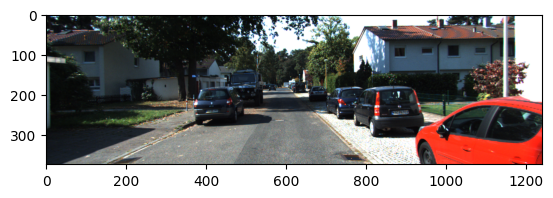

In [6]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

이미지와 라벨을 얻는 방법을 알게 되었습니다. 그렇다면 이렇게 얻은 이미지의 바운딩 박스(bounding box, bbox)를 확인하기 위해서는 어떻게 해야 할까요?

아래는 KITTI에서 제공하는 데이터셋에 대한 설명입니다.

```
데이터셋 이해를 위한 예시
Values    Name      Description
----------------------------------------------------------------------------
   1    type         Describes the type of object: 'Car', 'Van', 'Truck',
                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                     'Misc' or 'DontCare'
   1    truncated    Float from 0 (non-truncated) to 1 (truncated), where
                     truncated refers to the object leaving image boundaries
   1    occluded     Integer (0,1,2,3) indicating occlusion state:
                     0 = fully visible, 1 = partly occluded
                     2 = largely occluded, 3 = unknown
   1    alpha        Observation angle of object, ranging [-pi..pi]
   4    bbox         2D bounding box of object in the image (0-based index):
                     contains left, top, right, bottom pixel coordinates
   3    dimensions   3D object dimensions: height, width, length (in meters)
   3    location     3D object location x,y,z in camera coordinates (in meters)
   1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]
   1    score        Only for results: Float, indicating confidence in
                     detection, needed for p/r curves, higher is better.
```

![img](https://d3s0tskafalll9.cloudfront.net/media/images/GC-4-P-input.max-800x600.png)

![img](https://d3s0tskafalll9.cloudfront.net/media/images/GC-4-P-sample.max-800x600.png)

위 설명과 예시 이미지를 참고하셔서 이미지 위에 바운딩 박스를 그려서 시각화해 보세요!

Pillow 라이브러리의 ImageDraw 모듈을 참고하세요.

In [7]:
# objects['bbox']는 각 bbox에 대한 좌표를 비율로 나타냄
# 따라서 x_min, x_max, y_min, y_max를 구하기 위해서는 각 값에서 width 및 height를 곱해서 구해줘야 함
object_bbox = objects['bbox'].numpy()
print(object_bbox)

[[0.24994667 0.2973108  0.52168    0.40366346]
 [0.17834666 0.6147907  0.5295733  0.7669726 ]
 [0.28474668 0.56700486 0.51584    0.660314  ]
 [0.40186667 0.36808375 0.6414667  0.43763286]
 [0.41714665 0.53014493 0.526      0.56913847]
 [0.46928    0.501715   0.5439467  0.5234461 ]
 [0.00266667 0.7391385  0.5110667  0.99919486]]


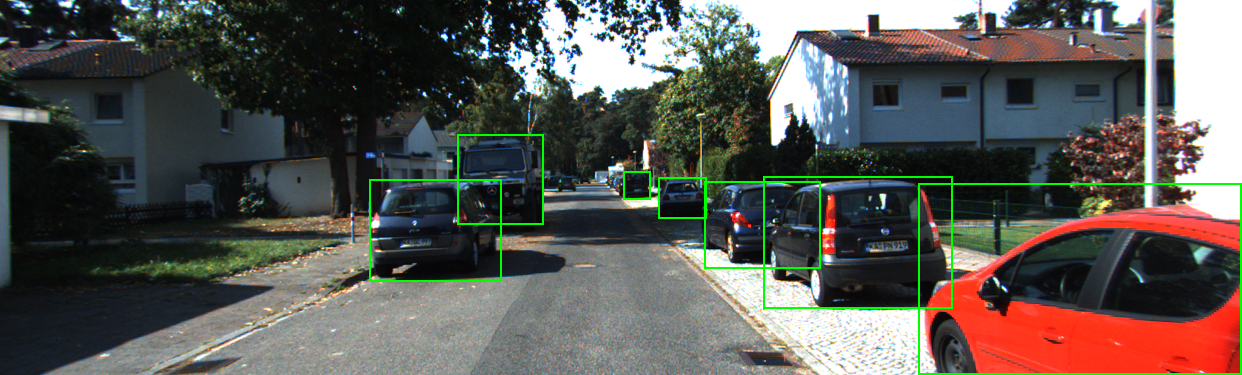

In [8]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    # 각 좌표를 rects에 stack 하고 각 rect값을 가져와서 그려줌
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for rect in rects:
        draw.rectangle(rect, outline=(0,255,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

```
<정답 예시>

def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())
```

In [9]:
# 데이터 파이프 라인의 단계
# 1. x와 y좌표 위치 교체
# 2. 무작위로 수평 뒤집기(Flip)
# 3. 이미지 크기 조정 및 패딩 추가
# 4. 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정


# x와 y좌표 위치 교체
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

# 무작위로 수평 뒤집기(Flip)
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

# 이미지 크기 조정 및 패딩 추가
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

# 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

In [10]:
# 위의 함수들 연결 및 적용
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

## Anchor Box

In [11]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

##### Anchor Box를 생성했으니 입력할 데이터를 Anchor Box에 맞게 변형: 데이터를 모델이 학습 가능한 형태로 바꿔 줄 수 있게 되었으니 모델 생성 

In [12]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [13]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

## Model

In [14]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

Object Detection의 라벨은 class와 box로 이루어지므로 각각을 추론하는 부분이 필요(그것을 head라고 부르기도 합니다.) 

Backbone에 해당하는 네트워크와 FPN을 통해 pyramid layer가 추출되고 나면 그 feature들을 바탕으로 <br>

1. class를 예상 <br>
2. box도 예상<br>

class와 box가 모두 맞을 수도, class와 box 중 하나만 맞을 수도, 둘 다 틀릴 수도 있겠죠? 
**class를 예측하는 head와 box를 예측하는 head가 별도로 존재한다는 것이 중요합니다.**
각각의 head를 만들어 줍니다. head부분은 유사한 형태로 만들 수 있으니 build_head라는 함수를 하나만 만들고 두 번 호출하면 될 것 같네요.

In [15]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

In [16]:
# backbone network로 ResNet50을 사용함
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

### RetinaNet을 완성해 봅시다. Backbone + FPN + classification용 head + box용 head 입니다.

In [17]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

## Loss Function

RetinaNet에서는 Focal Loss를 사용하는데요. Box Regression에는 사용하지 않고 Classification Loss를 계산하는데만 사용됩니다. Box Regression에는 Smooth L1 Loss를 사용
- Smooth L1 Loss을 사용하는 Box Regression에는 delta를 기준으로 계산이 달라지고, Focal Loss를 사용하는 Classification에서는 alpha와 gamma를 사용해서 물체일 때와 배경일 때의 식이 달라지는 점에 주의

In [18]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

## 모델 학습

In [19]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

/Users/louan/.pyenv/versions/3.9.13/envs/img/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


## Learning Rate

다음으로 Learning Rate입니다. 논문에서는 8개의 GPU를 사용했기 때문에 우리 환경과는 맞지 않아요. 그래서 Learning Rate를 적절히 바꿔줍니다.

Optimizer는 동일하게 SGD를 사용합니다.

In [20]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.legacy.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

## Pipeline for data preporcessing

In [21]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

In [23]:
model_dir = '../data/230223/checkpoints/'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

epochs = 2

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)

Epoch 1/2


2023-03-02 18:49:46.894233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3173/3173 [==============================] - ETA: 0s - loss: 0.9841

2023-03-02 20:51:35.428948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to ../data/230223/checkpoints/weights_epoch_1
3173/3173 [==============================] - 7470s 2s/step - loss: 0.9841 - val_loss: 1.2806
Epoch 2/2
3173/3173 [==============================] - ETA: 0s - loss: 0.7258
Epoch 2: saving model to ../data/230223/checkpoints/weights_epoch_2
3173/3173 [==============================] - 7732s 2s/step - loss: 0.7258 - val_loss: 1.1597


## 결과 확인

In [22]:
# (시간 관계상) 사전 학습된 모델 사용
# num_classes = 8
# batch_size = 2

# resnet50_backbone = get_backbone()
# loss_fn = RetinaNetLoss(num_classes)
# model = RetinaNet(num_classes, resnet50_backbone)

# learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
# learning_rate_boundaries = [125, 250, 500, 240000, 360000]
# learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
#     boundaries=learning_rate_boundaries, values=learning_rates
# )
# optimizer = tf.optimizers.legacy.SGD(learning_rate=learning_rate_fn, momentum=0.9)
# model.compile(loss=loss_fn, optimizer=optimizer)

model_dir = '../data/230223/checkpoints/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

- [tf.image.combined_non_max_suppression](https://www.tensorflow.org/api_docs/python/tf/image/combined_non_max_suppression)

In [24]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

이제 추론이 가능한 모델을 조립합니다.

In [25]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)


### 모델의 추론 결과 시각화

In [26]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [27]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

### 학습된 결과 확인

In [28]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
test_dataset.take(1)

<TakeDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'image/file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'objects': {'alpha': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'bbox': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), 'dimensions': TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), 'location': TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), 'occluded': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'rotation_y': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'truncated': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'type': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}}>

2023-03-02 23:43:37.034362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step


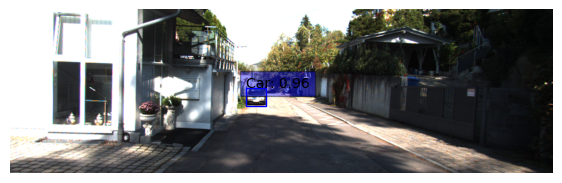

1/1 [==============================] - 0s 324ms/step


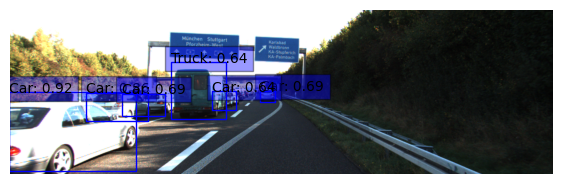

In [29]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

# Project

## 1. 자율주행 시스템 만들기
---
위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

- 입력으로 이미지 경로를 받습니다.
- 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
- 조건은 다음과 같습니다.
    - 사람이 한 명 이상 있는 경우
    - 차량의 크기(width or height)가 300px이상인 경우

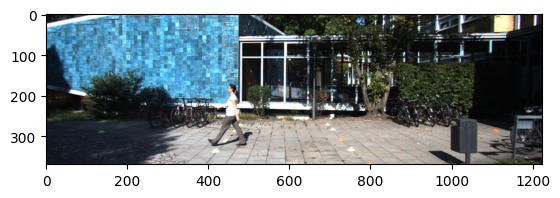

In [34]:
# test
img_path = '../data/230223/stop_2.png'
image = Image.open(img_path)
plt.imshow(image)
image = tf.cast(image, dtype=tf.float32)

1/1 [==============================] - 0s 422ms/step
CombinedNonMaxSuppression(nmsed_boxes=array([[[462.5751  ,  49.097214, 545.4715  , 225.74916 ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.  

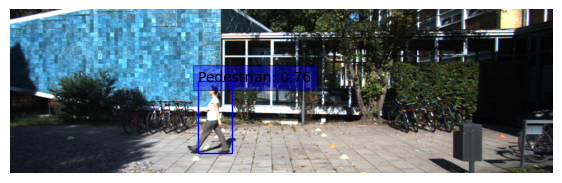

<AxesSubplot: >

In [35]:
# test
input_image, ratio = prepare_image(image)
detections = inference_model.predict(input_image)
print(detections)
num_detections = detections.valid_detections[0]
print(num_detections)
class_names = [int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]]
print(class_names)
visualize_detections(image, detections.nmsed_boxes[0][:num_detections] / ratio, class_names, detections.nmsed_scores[0][:num_detections],)


In [55]:
detections.nmsed_boxes[0][:num_detections][0]

array([462.5751  ,  49.097214, 545.4715  , 225.74916 ], dtype=float32)

In [57]:

print(float(w),h)

76.117919921875 tf.Tensor(162.20703, shape=(), dtype=float32)


In [72]:
img_path = '../data/230223/stop_4.png'

class_car = ['Car', 'Van', 'Truck','Tram']
class_person = ['Pedestrian', 'Person_sitting', 'Cyclist',]
class_misc = ['Misc', 'DontCare']

def self_drive_assist(img_path, size_limit=300):
    # 코드 구현

    image = Image.open(img_path)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]]

    visualize_detections(image, detections.nmsed_boxes[0][:num_detections] / ratio, class_names, detections.nmsed_scores[0][:num_detections],)
    
    for i in range(len(class_names)):
        if class_names[i] in class_person:
            return "Stop"
        if class_names[i] in class_car:
            x1, y1, x2, y2 = detections.nmsed_boxes[0][:num_detections][i] / ratio
            car_width, car_height = x2 - x1, y2 - y1
            print(car_width, car_height)
            if car_width >= 300 or car_height >= 300:
                return "Stop"
    return "Go"
            

print(self_drive_assist(img_path))


1/1 [==============================] - 0s 358ms/step
tf.Tensor(115.723755, shape=(), dtype=float32) tf.Tensor(81.038666, shape=(), dtype=float32)
tf.Tensor(83.477295, shape=(), dtype=float32) tf.Tensor(83.0531, shape=(), dtype=float32)
tf.Tensor(358.943, shape=(), dtype=float32) tf.Tensor(350.29623, shape=(), dtype=float32)
Stop


## 2. 자율주행 시스템 평가하기
---
아래 test_system() 를 통해서 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

1/1 [==============================] - 0s 363ms/step


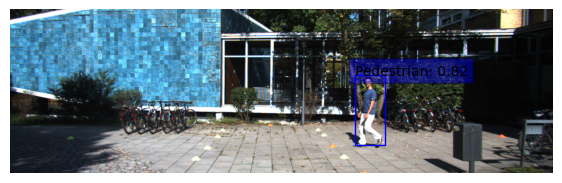

Stop
1/1 [==============================] - 0s 300ms/step


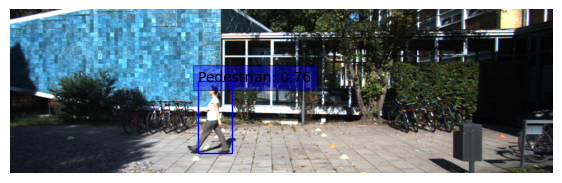

Stop
1/1 [==============================] - 0s 294ms/step


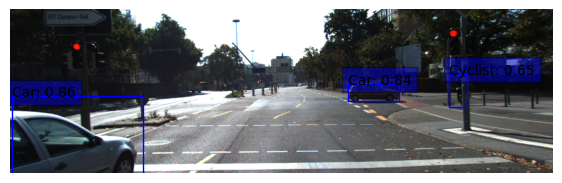

tf.Tensor(294.82422, shape=(), dtype=float32) tf.Tensor(179.867, shape=(), dtype=float32)
tf.Tensor(115.81189, shape=(), dtype=float32) tf.Tensor(40.211273, shape=(), dtype=float32)
Stop
1/1 [==============================] - 0s 276ms/step


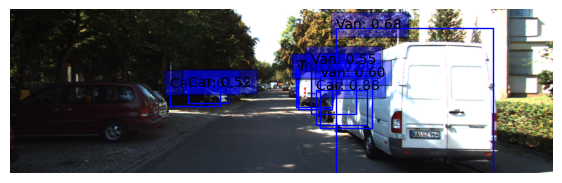

tf.Tensor(115.723755, shape=(), dtype=float32) tf.Tensor(81.038666, shape=(), dtype=float32)
tf.Tensor(83.477295, shape=(), dtype=float32) tf.Tensor(83.0531, shape=(), dtype=float32)
tf.Tensor(358.943, shape=(), dtype=float32) tf.Tensor(350.29623, shape=(), dtype=float32)
Stop
1/1 [==============================] - 0s 330ms/step


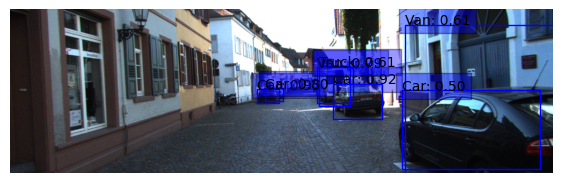

tf.Tensor(49.08795, shape=(), dtype=float32) tf.Tensor(31.09024, shape=(), dtype=float32)
tf.Tensor(113.54529, shape=(), dtype=float32) tf.Tensor(80.56286, shape=(), dtype=float32)
tf.Tensor(41.45874, shape=(), dtype=float32) tf.Tensor(29.69925, shape=(), dtype=float32)
tf.Tensor(80.634155, shape=(), dtype=float32) tf.Tensor(82.80095, shape=(), dtype=float32)
tf.Tensor(71.676575, shape=(), dtype=float32) tf.Tensor(91.501114, shape=(), dtype=float32)
tf.Tensor(343.70856, shape=(), dtype=float32) tf.Tensor(342.028, shape=(), dtype=float32)
Stop
1/1 [==============================] - 0s 271ms/step


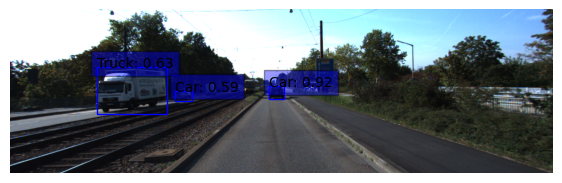

tf.Tensor(32.777527, shape=(), dtype=float32) tf.Tensor(30.084442, shape=(), dtype=float32)
tf.Tensor(159.35147, shape=(), dtype=float32) tf.Tensor(106.86049, shape=(), dtype=float32)
tf.Tensor(39.123077, shape=(), dtype=float32) tf.Tensor(24.011292, shape=(), dtype=float32)
Go
1/1 [==============================] - 0s 300ms/step


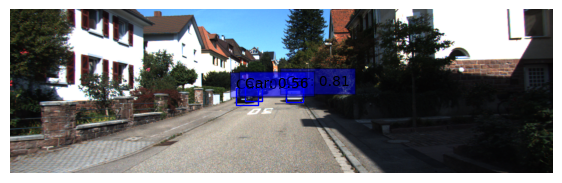

tf.Tensor(50.832825, shape=(), dtype=float32) tf.Tensor(37.018845, shape=(), dtype=float32)
tf.Tensor(39.20514, shape=(), dtype=float32) tf.Tensor(39.789078, shape=(), dtype=float32)
tf.Tensor(39.85956, shape=(), dtype=float32) tf.Tensor(30.125565, shape=(), dtype=float32)
Go
1/1 [==============================] - 0s 322ms/step


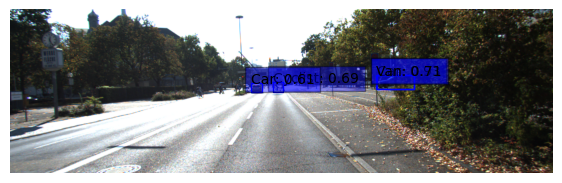

tf.Tensor(82.68866, shape=(), dtype=float32) tf.Tensor(31.365372, shape=(), dtype=float32)
tf.Tensor(84.86786, shape=(), dtype=float32) tf.Tensor(30.600967, shape=(), dtype=float32)
Stop
1/1 [==============================] - 0s 281ms/step


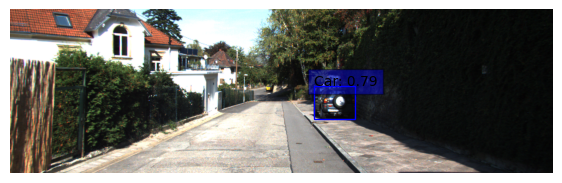

tf.Tensor(93.41052, shape=(), dtype=float32) tf.Tensor(76.14482, shape=(), dtype=float32)
Go
1/1 [==============================] - 0s 277ms/step


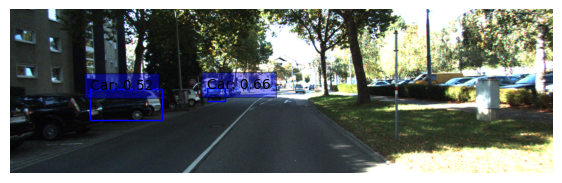

tf.Tensor(43.20273, shape=(), dtype=float32) tf.Tensor(28.533447, shape=(), dtype=float32)
tf.Tensor(164.8485, shape=(), dtype=float32) tf.Tensor(69.52273, shape=(), dtype=float32)
Go
90점입니다.


In [70]:
def test_system(func):
    work_dir = '../data/230223/'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)